In [1]:
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.cluster import KMeans #聚类模块
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf

devices = tf.config.experimental.list_physical_devices('GPU')
for dev in devices:
    tf.config.experimental.set_memory_growth(dev, True)

2023-09-25 19:30:10.430980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 19:30:10.625640: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-25 19:30:11.302023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-25 19:30:11.302132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
df = pd.read_pickle('output/df_pr_hyd.pkl.zstd', compression='zstd')

In [47]:
X = df.iloc[:, 7:]
Y = df['frames_count'] / 600

In [80]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=0)
# normalization
mean = train_x.mean(axis=0)
std = train_x.std(axis=0)
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [119]:
def my_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred) * tf.pow(tf.exp(1.0 - y_true), 2))

In [120]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss=my_loss, metrics=['mae'])

In [121]:
model.fit(train_x, train_y, epochs=10, batch_size=8, validation_split=0.2, validation_freq=1, shuffle=True)

Epoch 1/10
503/503 [==============================] - 3s 5ms/step - loss: 0.0531 - mae: 0.0464 - val_loss: 0.0590 - val_mae: 0.0343
Epoch 2/10
503/503 [==============================] - 3s 5ms/step - loss: 0.0509 - mae: 0.0431 - val_loss: 0.0553 - val_mae: 0.0392
Epoch 3/10
503/503 [==============================] - 3s 5ms/step - loss: 0.0495 - mae: 0.0491 - val_loss: 0.0551 - val_mae: 0.0820
Epoch 4/10
503/503 [==============================] - 3s 5ms/step - loss: 0.0492 - mae: 0.0519 - val_loss: 0.0545 - val_mae: 0.0474
Epoch 5/10
503/503 [==============================] - 3s 5ms/step - loss: 0.0491 - mae: 0.0520 - val_loss: 0.0540 - val_mae: 0.0748
Epoch 6/10
503/503 [==============================] - 3s 5ms/step - loss: 0.0493 - mae: 0.0526 - val_loss: 0.0552 - val_mae: 0.0403
Epoch 7/10
503/503 [==============================] - 3s 5ms/step - loss: 0.0490 - mae: 0.0520 - val_loss: 0.0540 - val_mae: 0.0599
Epoch 8/10
503/503 [==============================] - 3s 5ms/step - loss: 0.

In [122]:
model.evaluate(test_x, test_y, batch_size=32)

40/40 [==============================] - 0s 3ms/step - loss: 0.0623 - mae: 0.0417


[0.062254492193460464, 0.04169386252760887]

In [123]:
#  print predict and ground truth
pred_y = model.predict(test_x)
print(pred_y.flatten())
print(test_y.values)

40/40 [==============================] - 0s 2ms/step
[0.9807277  0.9578245  0.9969393  ... 0.97326374 0.9544193  0.9721457 ]
[0.99       0.995      0.985      ... 0.975      0.99       0.98833333]


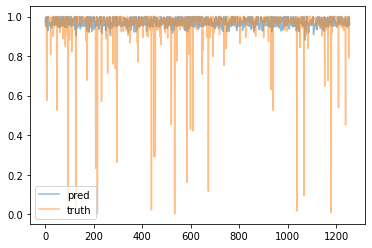

In [124]:
plt.plot(pred_y.flatten(), label='pred', alpha=0.5)
plt.plot(test_y.values, label='truth', alpha=0.5)
plt.legend()
plt.show()